<a href="https://colab.research.google.com/github/gal-dmitry/HSE_DUL/blob/hw_03/Homework3_autoregressive_flows.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone --single-branch https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 180, done.
remote: Counting objects: 100% (180/180), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 180 (delta 78), reused 134 (delta 49), pack-reused 0
Receiving objects: 100% (180/180), 28.64 MiB | 38.29 MiB/s, done.
Resolving deltas: 100% (78/78), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=15097 sha256=8124e836cb139b89d89431fea81ea49e3cbadb46213cd0c6e960450b1b3ec233
  Stored in directory: /tmp/pip-ephem-wheel-cache-kj3jdblc/wheels/55/59/29/0fb1c63565215773

In [2]:
from dul_2021.utils.hw3_utils import *


# Question 1: Autoregressive Flows for Images

Adapt your PixelCNN implementation from Homework 2 and use it as an autoregressive flow model on the black-and-white shapes dataset. Using the base architecture from Homework 2 1(a), output a mixture of logistics or gaussians (instead of logits), whose CDF we will use as our flow for each dimension of x. 

Remember: you must dequantize the data and scale it between 0 and 1 for the autoregressive flow to have stable training. 

**You will provide these deliverables**

1.   Over the course of training, record the average negative log-likelihood (nats / dim) of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. **Make sure to account for any rescaling you do in your nats/dim.**
2.   Report the final test set performance of your final model
3. 100 samples from your autoregressive flow. Our plotting code will show your samples, with and without clipping and flooring (to remove the quantization). 


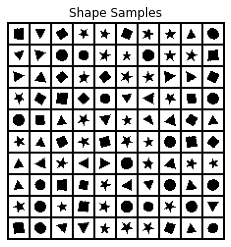

In [3]:
visualize_q1_data()

### Solution
Fill out the function below and return the necessary arguments. Feel free to create more cells if need be.

In [4]:
from torch import nn
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_
from torch.optim import Adam
import torch 

from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [22]:
class MaskedConv(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        mask = torch.zeros_like(self.weight)
        self.register_buffer("mask", mask)
        self.set_mask()

    def set_mask(self):
        raise NotImplementedError()

    def forward(self, x):
        return F.conv2d(x, self.mask * self.weight, 
                        bias=self.bias,
                        stride=self.stride,
                        padding=self.padding)
        

class ConvA(MaskedConv):
    def set_mask(self):
        h, w = self.kernel_size
        self.mask[:, :, h//2, :w//2] = 1
        self.mask[:, :, :h//2] = 1


class ConvB(MaskedConv):
    def set_mask(self):
        h, w = self.kernel_size
        self.mask[:, :, h//2, :w//2 + 1] = 1
        self.mask[:, :, :h//2] = 1


# class LayerNorm(nn.LayerNorm):
#     def __init__(self, *args, **kwargs):
#         super().__init__(*args, **kwargs)

#     def forward(self, x):
#         # print(f"LayerNorm | in:{x.shape, x.device}")
#         x = x.permute(0, 2, 3, 1).contiguous()
#         out = super().forward(x)
#         out = out.permute(0, 3, 1, 2).contiguous()
#         # print(f"LayerNorm | out:{out.shape, out.device}")
#         return out


class Residual(nn.Module):
    def __init__(self, cin, **kwargs):
        super().__init__()
        self.model = nn.Sequential(nn.ReLU(), ConvB(cin, cin//2, 1, **kwargs),
                                   nn.ReLU(), ConvB(cin//2, cin//2, 7, padding=3, **kwargs),
                                   nn.ReLU(), ConvB(cin//2, cin, 1, **kwargs))
        
    def forward(self, x):
        # print(f"Residual | in:{x.shape, x.device}")
        out = self.model(x)
        out += x
        # print(f"Residual | out:{out.shape, out.device}")
        return out


def custom_collate_fn(x):
    x = np.array(x).transpose(0, 3, 1, 2)
    # x = torch.tensor(x, dtype=torch.long)
    x = torch.FloatTensor(x)
    return x

In [6]:
from torch.distributions.uniform import Uniform
from torch.distributions.normal import Normal

In [7]:
def get_uniform(low, high, device):
    _low = torch.Tensor([low]).to(device)
    _high = torch.Tensor([high]).to(device)
    return Uniform(_low, _high)

In [27]:
class AutoregressiveFlowPixelCNN(nn.Module):

    def __init__(self, input_shape,
                 n_components=5, 
                 n_filters=120,
                 n_colors=2,
                 kernel_size=7,
                 middle_stack_size=8,
                 base_dist=get_uniform(0, 1, device)):
        
        super().__init__()
        self.input_shape = input_shape
        self.n_components = n_components
        self.n_filters = n_filters
        self.n_colors = n_colors
        self.kernel_size = kernel_size
        self.middle_stack_size = middle_stack_size
        self.base_dist = base_dist
        self.model = self.form_model()


    def form_model(self):
        c, h, w = self.input_shape

        start_stack = [ConvA(in_channels=c, 
                             out_channels=self.n_filters, 
                             kernel_size=self.kernel_size, 
                             padding=self.kernel_size//2),
                    #    LayerNorm(normalized_shape=self.n_filters),
                       nn.ReLU()]

        middle_stack = []
        for _ in range(self.middle_stack_size):
            middle_stack.extend([Residual(self.n_filters), 
                                #  LayerNorm(self.n_filters), 
                                 nn.ReLU()])

        finish_stack = ([ConvB(in_channels=self.n_filters, 
                               out_channels=self.n_filters, 
                               kernel_size=1), 
                         nn.ReLU(),
                         ConvB(in_channels=self.n_filters,
                               out_channels=3 * c * self.n_components, 
                               kernel_size=1)])
        
        layers = start_stack + middle_stack + finish_stack

        return nn.Sequential(*layers)


    def forward(self, x):
        batch_size = x.shape[0]
        # print(f"PixelCNN | in:{x.shape, x.device}")

        print(f"x.dtype: {x.dtype}")
        out = self.model(x)
        out = out.view(batch_size, 3 * self.n_components, *self.input_shape) 
        # print(f"PixelCNN | out:{out.shape, out.device}")
        return out 


    def direct_flow(self, x):

        pixelcnn_out = self(x)

        pi, mu, log_sigma = torch.chunk(pixelcnn_out, 3, dim=1)
        pi = F.softmax(pi, dim=1)
        dist = Normal(mu, log_sigma.exp())

        xr = x.unsqueeze(1).repeat(1, self.n_components, 1, 1, 1)
        
        z = (dist.cdf(xr) * pi).sum(dim=1)
        log_det = (dist.log_prob(xr).exp() * pi).sum(dim=1).log()
        
        subs = torch.tensor(2).log().to(device)
        log_det -= subs

        return z, log_det 


    def inverse_flow(self, pi, mu, log_sigma):
        n = pi.shape[0]
        sample_like = (n,)
        z = base_dist.sample(sample_like)

        xs = []

        for i in range(n):
            dist = Normal(mu[i], log_sigma[i].exp())
            def f(x):
                xr = np.repeat((x, self.n_components))
                xr = torch.FloatTensor(xr).to(device)
                return pi[i].dot(dist.cdf(xr)) - z[i]

            x = bisect(f, -20, 20)
            xs.append(x)

        return torch.FloatTensor(xs).to(device)


    def log_prob(self, x):
        z, log_det = self.direct_flow(x)
        z = torch.clip(z, 0, 1)
        log_p = (self.base_dist.log_prob(z) + log_det).mean(dim=(2, 3))
        return log_p

    
    def loss(self, x):
        return -self.log_prob(x).mean()


    def test(self, test_loader):
        cnt = 0
        total_loss = 0

        with torch.no_grad():
            for batch in test_loader:
                n = batch.shape[0]
                batch = batch.to(device)

                cnt += n
                total_loss += self.loss(batch) * n

        return total_loss / cnt
        # return total_loss.item() / cnt


    def fit(self, train_data, test_data, 
            batch_size=128,
            n_epoch=20,
            lr=1e-3):
        
        train_loader = DataLoader(train_data, 
                                  batch_size=batch_size, 
                                  shuffle=True,
                                  collate_fn=custom_collate_fn)

        test_loader = DataLoader(test_data,
                                 batch_size=batch_size,
                                 shuffle=False,
                                 collate_fn=custom_collate_fn)

        optimizer = Adam(self.parameters(), lr=lr)

        train_loss = []
        test_loss = [self.test(test_loader)]

        for epoch in tqdm(range(n_epoch), "Train | epochs"):
            for batch in train_loader:
                noise = torch.rand(batch.shape) / 2.0 # ?
                batch = (batch + noise).to(device)

                _loss = self.loss(batch)
                optimizer.zero_grad() 
                _loss.backward()

                clip_grad_norm_(self.parameters(), 1)
                optimizer.step()

                train_loss.append(_loss.cpu().data)
            test_loss.append(self.test(test_loader))

        return train_loss, test_loss


    def sample(self, n_samples=100):

        self.model.eval()
        c, h, w = self.input_shape
        samples = torch.zeros(n_samples, *self.input_shape).to(device)

        with torch.no_grad():
            for h_i in range(h):
                for w_j in range(w):
                    for c_k in range(c):
                        pixelcnn_sample = self(samples)[:, :, c_k, h_i, w_j]
                        pi, mu, log_sigma = torch.chunk(pixelcnn_sample, 3, dim=1)
                        pi = F.softmax(pi, dim=1)
                        samples[:, c_k, h_i, w_j] = self.inverse_flow(pi, mu, log_sigma)

        samples = torch.clip(samples, 0, 1)
        return samples.permute(0, 2, 3, 1).cpu().numpy()

In [28]:
def q1(train_data, test_data):
  """
  train_data: A (n_train, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  test_data: A (n_test, H, W, 1) uint8 numpy array of binary images with values in {0, 1}
  H = W = 20
  Note that you should dequantize your train and test data, your dequantized pixels should all lie in [0,1]

  Returns
  - a (# of training iterations,) numpy array of train_losses evaluated every minibatch
  - a (# of epochs + 1,) numpy array of test_losses evaluated once at initialization and after each epoch
  - a numpy array of size (100, H, W, 1) of samples with values in [0, 1], where [0,0.5] represents a black pixel
      and [0.5,1] represents a white pixel. We will show your samples with and without noise. 
  """
  
  _, h, w, c = train_data.shape
  image_new_shape = (c, h, w)

  model = AutoregressiveFlowPixelCNN(image_new_shape).to(device)

  train_loss, test_loss = model.fit(train_data, test_data)
  samples = model.sample(n_samples=100)

  return train_loss, test_loss, samples

### Results

Once you've implemented `q1`, execute the cells below to visualize and save your results



In [29]:
q1_save_results(q1)

x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32


Train | epochs:   0%|          | 0/20 [00:00<?, ?it/s]

x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: to

Train | epochs:   5%|▌         | 1/20 [15:18<4:50:59, 918.92s/it]

x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32
x.dtype: torch.float32


Train | epochs:   5%|▌         | 1/20 [16:27<5:12:44, 987.61s/it]


KeyboardInterrupt: ignored